# Quick start

In [230]:
import warnings
warnings.filterwarnings('ignore')

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, 
                             CountCB, MoranICB, PriorCB)

from trufl.optimizer import Optimizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
red, black = '#BF360C', '#263238'

### Create a vector grid from a given raster

In [233]:
fname_raster = '../files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

In [234]:
gdf_grid.head()

,loc_id,geometry
0,0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


<Axes: >

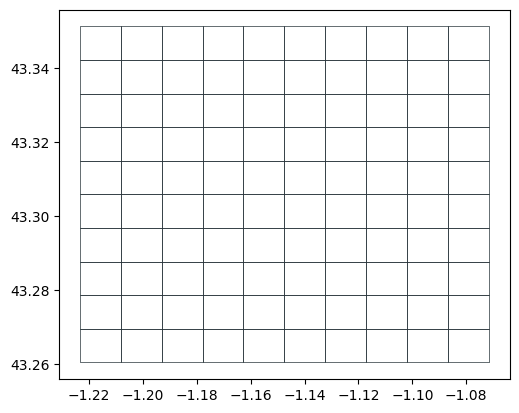

In [235]:
gdf_grid.boundary.plot(color=black, lw=0.5)

### Emulating data collection

#### Random sample

Generating a random set of points within a given polygon geoseries.

<Axes: >

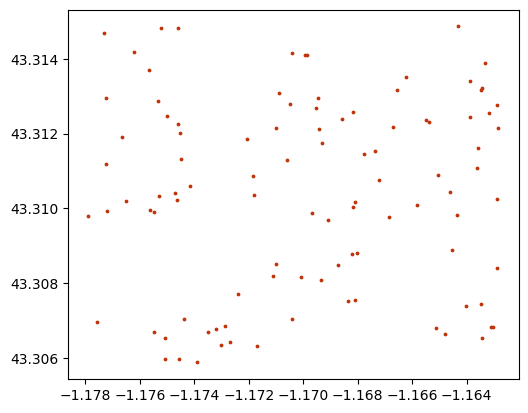

In [236]:
loc_id = 35
n_pts = 100
sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n_pts)
sampling_locs.plot(markersize=3, color=red)

In [237]:
sampling_locs

35    MULTIPOINT (-1.17789 43.30979, -1.17759 43.306...
Name: sampled_points, dtype: geometry

#### Emulate data collection

We will simulate a data collection process over a set of areas, which could be administrative units or a gridded version of them. For each area, we will specify the number of measurements to be taken, which we will simulate by generating random numbers between 1 and 100.

For each area, we will follow the following steps:

- **Generate random sample locations**: we will create a set of random coordinates within the bounds of the area, where we will simulate the collection of data.
- **Emulate measurement data**: for each sample location, we will extract the corresponding value from a given raster dataset, which we will use to simulate the actual measurement.

This iterative process will allow us to generate a simulated dataset of measurements, which we can then use for further analysis and modeling.

We will emulate data collection from the raster shown below:

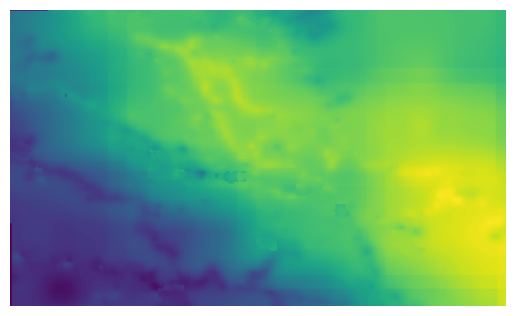

In [238]:
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))

Let's start with a single area as an example:

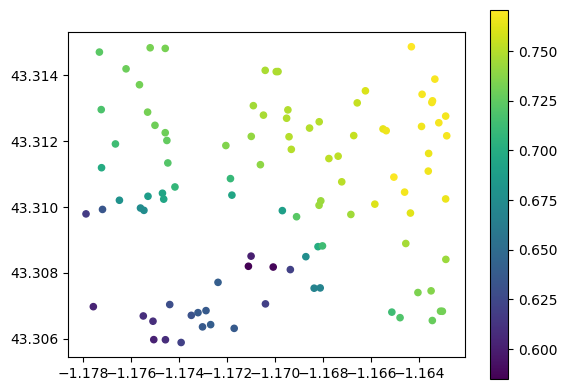

In [239]:
sampler = Sampler(fname_raster)
gdf_samples = sampler.sample(sampling_locs)
gdf_samples.plot(column='value', s=20, legend=True);

In [240]:
gdf_samples.head()

,loc_id,geometry,value
0,35,POINT (-1.17789 43.30979),0.616764
1,35,POINT (-1.17759 43.30697),0.603114
2,35,POINT (-1.17733 43.31470),0.722999
3,35,POINT (-1.17726 43.31295),0.718280
4,35,POINT (-1.17724 43.31119),0.698141


Than for all areas iteratively:

In [241]:
sampler = Sampler(fname_raster)
n_planned = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)

In [242]:
gdf_samples_t0.head()

,loc_id,geometry,value
0,0,POINT (-1.22336 43.26765),0.000000
1,0,POINT (-1.22149 43.26189),0.139331
2,0,POINT (-1.22007 43.26351),0.144891
3,0,POINT (-1.21935 43.26757),0.143115
4,0,POINT (-1.21899 43.26158),0.140682


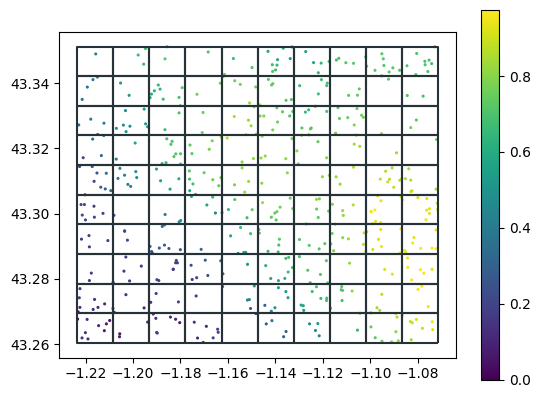

In [243]:
ax = gdf_samples_t0.plot(column='value', s=1.5, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

### Getting current state

In [244]:
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB(), 
                               CountCB(), MoranICB(k=5), 
                               PriorCB(gdf_grid, fname_raster)])

In [245]:
state.get(loc_id=2, as_numpy=True)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I',
        'Moran_p_sim', 'Prior'], dtype='<U18'),
 array([0.17192762, 0.15294629, 0.00776905, 3.        , 0.35116787,
        0.006     , 0.16180228]))

## Build the ranking of polygons based on several criteria

### Criteria
- MaxCB()
- MinCB()
- StdCB()
- CountCB()
- MoranICB(k=5)
- PriorCB

### Criteria type 
- Benefit (high values --> high score --> rank high --> prioritized sampling needed)
- Cost (high values --> low score --> low high --> Less sampling needed)

- MaxCB() -- Benefit
- MinCB() -- ???
- StdCB() -- Benefit
- CountCB() -- Cost (Low count -- higher priority because more samples need)
- MoranICB(k=5) -- Cost (high value -- highly correlated -- less need for sampling ?? )
- PriorCB -- Benefit



In [246]:
state = State(gdf_samples_t0, [StdCB(), PriorCB(gdf_grid, fname_raster)])
optimizer = Optimizer(state = state)
matrix = optimizer.build_matrix(polygon_list = gdf_samples_t0.loc_id.unique())
optimizer.build_weight_vector(weight_vector = [0.5, 0.5],
                              benefit_vector = [True, True])
ranking = optimizer.rank()


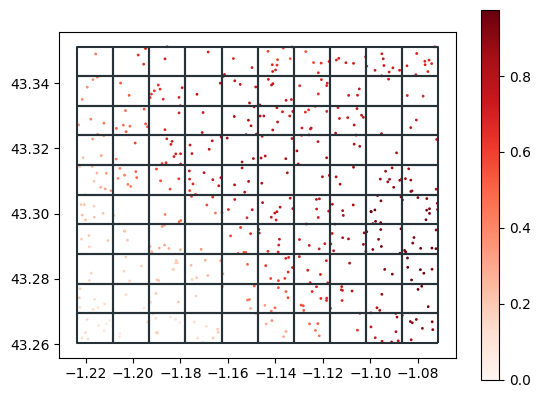

In [247]:
gdf_samples_t0['MCDM_value_grid'] = [ranking[loc_id][1] for loc_id in gdf_samples_t0['loc_id']]
gdf_samples_t0

ax = gdf_samples_t0.plot(column='value', s=1, legend=True, colormap='Reds')
gdf_grid.boundary.plot(color=black, ax=ax);
